<a href="https://colab.research.google.com/github/YejuHAM/Yeju-Ham-project1/blob/main/n222a_random_forests_%EC%B5%9C%EC%A2%85%EC%A0%9C%EC%B6%9C(%EC%9D%B8%EC%BD%94%EB%8D%94_%EB%B3%91%ED%95%A9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 2*

# 📝 Assignment
---

# 랜덤포레스트(Random Forests)

### 1) 캐글 대회를 이어서 진행합니다. EDA, 데이터 전처리 부분을 업데이트 하세요.
- EDA는 항상 완벽할 수 없지요 한 주간 계속 같은 데이터로 과제를 진행하므로 부족한 부분을 추가하거나 논하세요.
- (지금은 feature engineering에 너무 시간을 들이지 마세요!)
- Ordinal Encoding을 적용해 보세요.
- **(객관식) 다음 특성들 중에 순서를 고려한 Ordinal Encoding이 필요해 보이는 특성을 선택하고 과제 제출폼에 제출하세요.**
    1. opinion_h1n1_vacc_effective
    2. state
    3. marital
    4. employment_occupation


In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
!pip install category-encoders
!pip install -U pandas-profiling

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

In [ ]:
target = 'vacc_h1n1_f'

train = pd.merge(pd.read_csv('/gdrive/MyDrive/Colab Notebooks/vaccine data/train_labels.csv'), 
                 pd.read_csv('/gdrive/MyDrive/Colab Notebooks/vaccine data/train.csv'), left_index=True, right_index=True)

test = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/vaccine data/test.csv')
sample_submission = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/vaccine data//submission.csv')

In [ ]:
#훈련, 검증데이터 나누기
train, val = train_test_split(train, test_size = 0.2, stratify = train[target], random_state = 2)
#여기서 stratify는 train[target]의 비율과 동일하게 0과 1을 가지겠다라는 것

print(train.shape, val.shape, test.shape)

(33723, 40) (8431, 40) (28104, 38)


In [ ]:
#결측치 확인
train.isnull().sum() #매우 많은 -> 나중에 imputer로 처리

In [ ]:
#중복값 확인 
train.T.duplicated().sum()  # =>중복값 없음

0

In [ ]:
#cardinality확인
train.describe(exclude='number').T.sort_values(by='unique')

#state는 52개, employment_industry = 23, employment_occupation = 25

,count,unique,top,freq
employment_status,25466,3,Employed,13722
census_msa,33583,3,"MSA, Not Principle City",15116
opinion_h1n1_vacc_effective,26637,6,Somewhat Effective,11710
opinion_h1n1_risk,26602,6,Somewhat Low,9980
opinion_h1n1_sick_from_vacc,26568,6,Not Very Worried,9229
opinion_seas_vacc_effective,26519,6,Somewhat Effective,11571
opinion_seas_risk,26466,6,Somewhat Low,9057
opinion_seas_sick_from_vacc,26413,6,Not At All Worried,11813
agegrp,33583,7,65+ Years,6821
employment_industry,13714,23,Health Care and Social Assistance Industries,2451


In [ ]:
#피쳐와 타겟 분리
features = train.drop(columns=[target]).columns

#훈련/검증/테스트 데이터로 분리
X_train = train[features]
y_train =train[target]
X_val = val[features]
y_val = val[target]
#X_test = test[features]
#y_test에는 타겟값이 당연히 없음

In [ ]:
print(y_train.value_counts(normalize=True))
major = y_train.mode()
y_pred = [major]*len(y_train)

from sklearn.metrics import accuracy_score
print('기준모델 정확도:', accuracy_score(y_train, y_pred))
#이걸 굳이 안해봐도 분류의 기준모델은 더 많은 쪽의 비중이다.

0    0.760935
1    0.239065
Name: vacc_h1n1_f, dtype: float64
기준모델 정확도: 0.7609346736648578


#여기서부터 전과제와 달라지는 부분


문제) 다음 특성들 중에 순서를 고려한 Ordinal Encoding이 필요해 보이는 특성을 선택하고 과제 제출폼에 제출하세요.

opinion_h1n1_vacc_effective
state
marital
employment_occupation

풀이: Ordinal Encoding은 중요도, 순번 등 '순서'에 가치부여가 필요한 특성이 좋다. 

In [ ]:
#1) opinion_h1n1_effective
print('1)opinion_h1n1_effective\n')
print(train["opinion_h1n1_vacc_effective"].value_counts())
print('5가지 순서로 효과를 측정함. 이는 순서가 중요한 칼럼이다.')

#2) state
print('\n2)state\n')
print(train['state'].value_counts())
print('주는 그냥 미국 내의 주를 나타냄 각각이 독립적인 레벨이다.\ncardinality문제때문에 ordinal로 순서를 매기는 것이 좋으나 이건은 우위나 순서가 있지 않다.')

#3) martial
print('\n3)marital')
print(train['marital'].value_counts())
print('결혼여부, ordinal 필요없음. binary데이터')

#4) employment_occupation
print('\n4)employment_occupation')
print(train['marital'].value_counts())
print('주랑 비슷함')

In [ ]:
#EDA연습

#1. 지역관련 칼럼 통합
#미국에서는 관할구역을 지정하고 Branch office를 설치해 운영한다. 
#백신은 보건곤련 정보이다. 

X_train['hhs_region'].value_counts().sort_index()

#census_region, census_msa 인구 밀도/분포와 관련되어 있다. ->더 관련이 높은 region만 남김
X_train = X_train.drop(columns = ['census_msa'], axis = 1)
X_val = X_val.drop(columns = ['census_msa'], axis = 1)
test = test.drop(columns = ['census_msa'], axis = 1)



In [ ]:
#2. 거주 구성원 - 어른/아이 확인
X_train[["n_adult_r", "household_children", "n_people_r"]].describe()

#가족 구성원 중 어린이 인원의 비율 칼럼 만들기
X_train['proportion_child'] = round(X_train['household_children']/X_train['n_people_r']*100,1)
X_val['proportion_child'] = round(X_val['household_children']/X_val['n_people_r']*100,1)
test['proportion_child'] = round(test['household_children']/test['n_people_r']*100,1)


In [ ]:
X_train.shape, X_val.shape, test.shape

((33723, 39), (8431, 39), (28104, 38))

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

#매우 중요하고 궁금했던 부분:
#특성별로 인코더를 따로 지정할 수 있을까?

In [ ]:
#필요없는 두 번째 타겟변수 드랍
X_train = X_train.drop(['vacc_seas_f'], axis = 1)
X_val = X_val.drop(['vacc_seas_f'], axis = 1)

In [ ]:
#one-hot할 특성
onehot = ['agegrp','employment_status']

#ordinal 할 특성
ordinal = ['opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_h1n1_sick_from_vacc',
           'opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc','employment_industry',	'employment_occupation',	'state' ]

           #employment_industry,	employment_occupation,	state 는 순서형 데이터는 아니지만 레벨이 너무 많아서 과적합 될 것 같아, ordinal로 넣음. 후에 해석시 주의의

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# 1)모든 특성을 일괄적으로 onehotencoding
pipe1 = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    RandomForestClassifier(n_jobs = -1, random_state = 10, oob_score = True)
)

pipe1.fit(X_train, y_train)
print('원핫인코딩 검증 정확도:', pipe1.score(X_val, y_val))

y_pred1 = pipe1.predict(X_val)
print('원핫인코딩 검증 f1:', f1_score(y_val, y_pred1))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


원핫인코딩 검증 정확도: 0.8303878543470525
원핫인코딩 검증 f1: 0.560540872771973


In [ ]:
# 2. 모든 특성을 일괄적으로 OrdinalEncoding
pipe2 = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe2.fit(X_train, y_train)
print('검증 정확도: ', pipe2.score(X_val, y_val))

y_pred2 = pipe2.predict(X_val)
print('검증 f1: ', f1_score(y_val, y_pred2))

검증 정확도:  0.8273039971533626
검증 f1:  0.5587878787878787


In [ ]:
# 3. 인코딩 병합
pipe3 = make_pipeline(
    OneHotEncoder(use_cat_names=True, cols = onehot),
    OrdinalEncoder(cols = ordinal),
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe3.fit(X_train, y_train)
print('검증 정확도: ', pipe3.score(X_val, y_val))

y_pred3 = pipe3.predict(X_val)
print('검증 f1: ', f1_score(y_val, y_pred3))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


검증 정확도:  0.8268295575851026
검증 f1:  0.5529699938763013


In [ ]:
# 4. 인코딩 병합 + 파라미터 조정
pipe4 = make_pipeline(
    OneHotEncoder(use_cat_names=True, cols = onehot),
    OrdinalEncoder(cols = ordinal),
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True, max_depth=10)
)

pipe4.fit(X_train, y_train)
print('검증 정확도: ', pipe4.score(X_val, y_val))

y_pred4 = pipe4.predict(X_val)
print('검증 f1: ', f1_score(y_val, y_pred4))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


검증 정확도:  0.8280156565057526
검증 f1:  0.5236530880420499


#아래는 내가 해본 것들

In [ ]:
X_train.select_dtypes(include = 'object')

,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,agegrp,employment_status,employment_industry,employment_occupation,state
20365,Somewhat Effective,Somewhat Low,Not At All Worried,Very Effective,Somewhat Low,Not At All Worried,18 - 34 Years,Employed,"Professional, Scientific, and Technical Servic...",Office and Administrative Support Occupations,NEW JERSEY
29138,Somewhat Effective,Somewhat High,Not Very Worried,Somewhat Effective,Somewhat Low,Not Very Worried,35 - 44 Years,Unemployed,NaN,NaN,IOWA
36128,Not Very Effective,Very Low,Dont Know,Somewhat Effective,Very Low,Very Worried,65+ Years,Not in Labor Force,NaN,NaN,OREGON
39793,Very Effective,Somewhat Low,Not Very Worried,Somewhat Effective,Very Low,Not At All Worried,55 - 64 Years,Employed,"Arts, Entertainment, and Recreation Industries...",Business and Financial Operations Occupations,IOWA
32973,Not At All Effective,Somewhat Low,Not At All Worried,Not At All Effective,Very Low,Not At All Worried,18 - 34 Years,Not in Labor Force,NaN,NaN,IOWA
...,...,...,...,...,...,...,...,...,...,...,...
8747,NaN,NaN,NaN,NaN,NaN,NaN,6 Months - 9 Years,NaN,NaN,NaN,ILLINOIS
4412,Not Very Effective,Somewhat High,Very Worried,Not Very Effective,Very High,Very Worried,55 - 64 Years,Not in Labor Force,NaN,NaN,INDIANA
19064,NaN,NaN,NaN,NaN,NaN,NaN,6 Months - 9 Years,NaN,NaN,NaN,GEORGIA
40906,NaN,NaN,NaN,NaN,NaN,NaN,10 - 17 Years,NaN,NaN,NaN,MONTANA


In [ ]:
X_train['employment_status'].value_counts()

Employed              13722
Not in Labor Force    10254
Unemployed             1490
Name: employment_status, dtype: int64

In [ ]:
#결정트리 One-hot-encoding모델
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    DecisionTreeClassifier(max_depth=5, random_state = 2))

pipe.fit(X_train, y_train)

print('훈련 정확도:', pipe.score(X_train, y_train))
print('검증 정확도:', pipe.score(X_val, y_val))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도: 0.8237701272128815
검증 정확도: 0.8231526509310877


In [ ]:
#결정트리 & Oridinal encoding 적용
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=2, max_depth = 5)
)

pipe.fit(X_train, y_train)

print('훈련 정확도:', pipe.score(X_train, y_train))
print('검증 정확도:', pipe.score(X_val, y_val))
print('신기한게, Ordinal encoding에서는 훈련정확도보다 검증정확도가 더 높게 나옴. \n그러나 얘네는 onehot을 사용한 것보다는 전체적으로 정확도가 떨어짐 ')

훈련 정확도: 0.8151445671917339
검증 정확도: 0.8194757442770727
신기한게, Ordinal encoding에서는 훈련정확도보다 검증정확도가 더 높게 나옴. 
그러나 얘네는 onehot을 사용한 것보다는 전체적으로 정확도가 떨어짐 


### 2) 랜덤포레스트 모델을 적용한 후의 결과를 캐글에 제출하세요.
- 랜덤포레스트를 적용하고 성능이 오히려 떨어졌을 수도 있습니다! 만약 그렇다면 이유를 본인 논리로 분석해 보세요.
- **캐글 Leaderboard의 본인 Score를 과제 제출폼에 제출하세요.**

In [ ]:
#랜덤포레스트 & One-Hot 인코딩
from sklearn.ensemble import RandomForestClassifier

pipe_rd = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    RandomForestClassifier(n_jobs = -1, random_state = 2, oob_score= True)
)

pipe_rd.fit(X_train, y_train)
print('랜덤포레스트 & 원핫 검증정확도:', pipe_rd.score(X_val, y_val))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


랜덤포레스트 & 원핫 검증정확도: 0.8255248487723876


In [ ]:
#랜덤포레스트 모델 적용하기
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

pipe_or = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs = -1, random_state = 2, oob_score= True)
)

pipe_or.fit(X_train, y_train)
print('랜덤 포레스트 & Ordinal 검증정확도:', pipe_or.score(X_val, y_val))
print('랜덤 포레스트와 Ordinal 사용하니까 검증정확도에서는 약간 정확도가 떨어짐 ')

#여기서 attribute인 oob_score는 out-of-bag estimate사용하냐 안하냐를 나타내는 것


#근데 만약 성능이 떨어졌다고 하면 이는 무슨의미인지?

랜덤 포레스트 & Ordinal 검증정확도: 0.8236270904993477
랜덤 포레스트와 Ordinal 사용하니까 검증정확도에서는 약간 정확도가 떨어짐 


In [ ]:
#훈련, 검증 세트 스코어 확인(F1스코어)

from sklearn.metrics import f1_score

y_pred_train = pipe_or.predict(X_train)
y_pred_val = pipe_or.predict(X_val)

print('훈련세트 f1 score:', f1_score(y_train, y_pred_train))
print('검증세트 f1 score:', f1_score(y_val, y_pred_val))

#너무 과적합임 다시 파라미터 조정해보기

훈련세트 f1 score: 0.9940761987902974
검증세트 f1 score: 0.5453989605625191


In [ ]:
#성능 높여보기(시도1)
pipe_or = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs = -1, random_state = 2, oob_score= True, max_depth=25, min_samples_leaf= 3)
)

pipe_or.fit(X_train, y_train)
print('랜덤 포레스트 & Ordinal 검증정확도:', pipe_or.score(X_val, y_val))

y_pred_train = pipe_or.predict(X_train)
y_pred_val = pipe_or.predict(X_val)

print('훈련세트 f1 score:', f1_score(y_train, y_pred_train))
print('검증세트 f1 score:', f1_score(y_val, y_pred_val))

랜덤 포레스트 & Ordinal 검증정확도: 0.8313367334835725
훈련세트 f1 score: 0.7602664519434887
검증세트 f1 score: 0.560840024706609


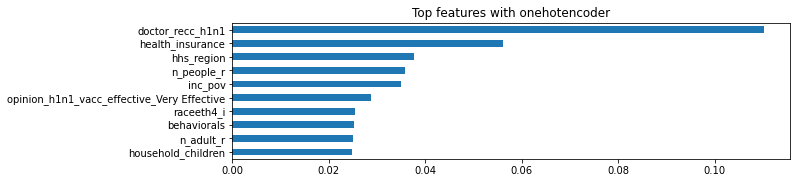

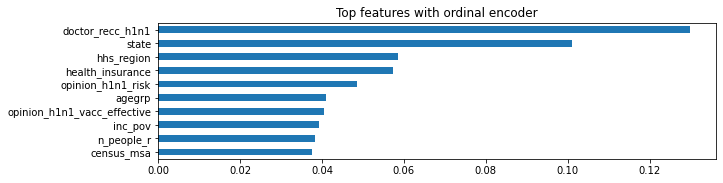

In [ ]:
#랜덤 포레스트의 특성 중요도 비교(onehot vs ordinal)

#특성 중요도 one-hot
rf_onehot = pipe_rd.named_steps['randomforestclassifier']
colnames = pipe_rd.named_steps['onehotencoder'].get_feature_names()
importances = pd.Series(rf_onehot.feature_importances_, colnames)

n=10
plt.figure(figsize =(10,n/4))
plt.title('Top features with onehotencoder')
importances.sort_values()[-10:].plot.barh();

#특성중요도 ordinal
rf_ordinal = pipe_or.named_steps['randomforestclassifier']
colnames = pipe_or.named_steps['ordinalencoder'].get_feature_names()
importances = pd.Series(rf_ordinal.feature_importances_, colnames)

plt.figure(figsize =(10,n/4))
plt.title('Top features with ordinal encoder')
importances.sort_values()[-10:].plot.barh();

인코딩을 다르게 해 본 결과 ordinal인코딩에서 state, opinion_h1n1_risk, agegrp 등의 결과가 불순도를 걸러주는 중요한 피쳐인 것을 알 수 있음 


ordinalencoder를 사용해 무작위로 수치에 번호를 매기는 인코딩을 했지만, 범주의 순위를 정확하게 알고 있으면 mapping파라미터를 사용해 지정할 수 있다. 

##여기서부터는 최적의 파라미터 찾기 위한 개인노력

In [ ]:
#하이퍼 파라미터 조정하면서 해보기
pipe_rd = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs = -1, random_state = 2, oob_score= True)
)

from pprint import pprint
print('Parameters currently in use:\n')
pprint(pipe_rd['randomforestclassifier'].get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}


In [ ]:
#Random Search with Cross Validation

from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#minimum number of samples required to split  node
min_samples_split = [2,5,10]
#minimum number of samples required at each leaf node
min_samples_leaf= [1,2,4]
#mothod of selecting samples for trainnig each tree
bootstrap = [True, False]

#Create the random grid(랜덤 그리드를 만들어보자)
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
#만든 랜덤 그리드를 사용해 베스트 하이퍼마라미터를 찾아보자

#일단 기준모델 만들기
%%time
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)

#RandomizedSearchCV에서 제일 중요한 것은 n_iter과 cv의 개수인다. 
#3개의 cv를 사용해보자. n_iter= 100으로 하자. n_iter은 다른 콤비네이션을 몇 번 시도할 것인지를 정한다. 
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

#파이프에 넣어서 전처리 하고 랜덤서치 검증 돌리기
pipe_temp =make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    rf_random
)

pipe_temp.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 39.2min


In [ ]:
pipe.temp.best_parmas_

In [ ]:
#캐글에 파일제출
y_pred_test = pipe_or.predict(X_test)
sub = pd.read_csv('submission.csv')
sub['vacc_h1n1_f']=y_pred_test
sub.to_csv('sub.csv', index = False)

In [ ]:
pd.read_csv('/content/sub.csv')

,Id,vacc_h1n1_f
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
28099,28099,0
28100,28100,0
28101,28101,0
28102,28102,0



## 🔥 도전과제

### 3) 수업에 사용하지 않은 다른 종류의 [category_encoders](http://contrib.scikit-learn.org/category_encoders/)을 적용해 보고 인코더에 대해 설명하세요


In [ ]:
### 이곳에서 과제를 진행해 주세요 ###

## 참고자료

- [Random Forests for Complete Beginners](https://victorzhou.com/blog/intro-to-random-forests/)